Using the `tiling` Python's environment.

# Visualisation of tiles normalisation results

In this notebook I'm going to visualise the results of the normalisation on the single tiles.\
Different algorithms and target images/parameters have been used:

- from HistomicsTK:
    - Reinhard with masking
    - Reinhard without masking
    - Macenko with masking
    - Macenko without masking
- from StainTools:
    - Reinhard
    - Macenko
    - Vahadane
- from TorchVahadane:
    - Vahadane on CPU
    - Vahadane on GPU
- from StainNET
    - StainNET pre-trained with the Camelyon16 breast cancer dataset
    - StainGAN model A pre-trained with the Camelyon16 breast cancer dataset
    - StainGAN model B pre-trained with the Camelyon16 breast cancer dataset

In most of the cases these are the same methods applied different times, so they should return the same results. However, the different in using or not using the masks should be visible.

---
# 0. - Imports and paths

In [28]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image, ImageDraw
import math 

In [2]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Regular.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

# sns.set_theme(font_scale=1.5, style="whitegrid")
# biomodal_palette = ["#9CDBD9", "#C0DF16","#003B49","#05868E", "#ABAD9A", "#F87C56","#00DAEF","#50B37B"]
# sns.set_palette(biomodal_palette)

/disk2/user/gabgam/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


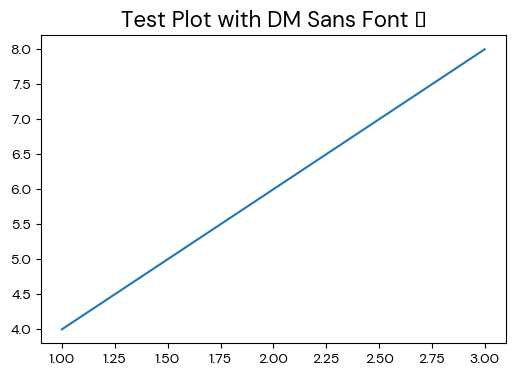

In [3]:
# Test plot
plt.figure(figsize=(6, 4))
plt.title("Test Plot with DM Sans Font μ", fontsize=16)
plt.plot([1, 2, 3], [4, 6, 8])
plt.show()


In [4]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/2_image_normalisation/")
print(os.getcwd())

# PARAMETER THAT MUST BE SPECIFIED TO AUTOMATICALLY LOOK FOR THE CORRECT FOLDERS AND PATHS
IMAGE_VERSION_AND_COORDINATE_SYSTEM = "v3_allspots" 
SPATIAL_ATAC_SAMPLE = "satac_C1"

# path to all wsi-derived tiles directories, including normalised WSI
PATH_TO_TILES_DIRECTORY = f"/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/outputs/{SPATIAL_ATAC_SAMPLE}/tiling_output/"
# all wsi-derived tiles directories
paths_to_tiles_from_wsis = [os.path.join(PATH_TO_TILES_DIRECTORY, i) for i in os.listdir(PATH_TO_TILES_DIRECTORY) if i.startswith(IMAGE_VERSION_AND_COORDINATE_SYSTEM)] # all the folder for tiles from WSIs, including the original one
print(paths_to_tiles_from_wsis)

# path to directories of singularly normalised tiles
PATH_TO_NORMALISED_TILES = f"/disk2/user/gabgam/work/gigi_env/the_project/2_image_normalisation/output/{SPATIAL_ATAC_SAMPLE}/{IMAGE_VERSION_AND_COORDINATE_SYSTEM}/"

/disk2/work/gabgam/gigi_env/the_project/2_image_normalisation
['/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/outputs/satac_C1/tiling_output/v3_allspots', '/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/outputs/satac_C1/tiling_output/v3_allspots_histomicsTK_macenko_nomasking_target_is_reference_full', '/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/outputs/satac_C1/tiling_output/v3_allspots_histomicsTK_macenko_withmasking_target_is_reference_full', '/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/outputs/satac_C1/tiling_output/v3_allspots_staintools_reinhard_target_is_reference_full']


# 1. - Visualisation

First of all, let's see how many tiles where normalised for each method:

In [5]:
def normalisations_summary_from_tiles(base_dir):
    '''
    Returns a dataframe containing the number of tiles (as `.jpg` files) per normalisation method, target and the relative path.
    '''
    # Initialize a list to hold the data for the DataFrame
    data = []
        
    # Walk through the directory structure
    for root, dirs, files in os.walk(base_dir):
        # Filter .jpg files
        jpg_count = len([f for f in files if f.lower().endswith('.jpg')])

        # Parse normalization method and target from the directory structure
        relative_path = os.path.relpath(root, base_dir)
        path_parts = relative_path.split(os.sep)

        # Initialize variables
        normalization_method = path_parts[0] if len(path_parts) >= 1 else None
        target = "-"

        # Check for specific targets or models in deeper paths
        if len(path_parts) > 1:
            if path_parts[1].startswith("target"):
                target = path_parts[1]
            elif path_parts[1].startswith("model"):
                normalization_method = f"{normalization_method}_{path_parts[1]}"

        # Add the data row if a normalization method is valid
        if normalization_method:
            data.append({
                "Normalization Method": normalization_method,
                "Target": target,
                "Number of tiles": jpg_count,
                #"Path to folder": relative_path # path to the final folder as well
                "Path to folder": root # path to the final folder as well
            })
            
    
    # Create a DataFrame and filter for methods that worked
    df = pd.DataFrame(data)
    df = df[df["Number of tiles"] > 0]

    # Optionally, sort the DataFrame for better readability
    df = df.sort_values(by=["Normalization Method", 
                            "Target"]).reset_index(drop=True)
    
    return df


def normalisations_summary_from_WSI(base_dir, original_image_name):
    '''
    Returns a dataframe containing the number of tiles (as `.jpg` files) per normalisation method, target and the relative path derived from the original or normalised WSI.
    '''
    # Initialize a list to hold the data for the DataFrame
    data = []
    
    # Filter .jpg files
    jpg_count = len([f for f in os.listdir(base_dir) if f.lower().endswith('.jpg')])
    
    temp_method_n_target = base_dir.split("/")[-3]
    print(f"Processing folder: {temp_method_n_target}")
    temp_for_naming = temp_method_n_target.split("_")
    
    if temp_method_n_target == original_image_name:
        normalization_method = "ORIGINAL WSI"
        target = "-"
    
    elif (temp_for_naming[0] + "_" + temp_for_naming[1]) == original_image_name and len(temp_for_naming) > 2:
        normalization_method = temp_method_n_target.replace((original_image_name + "_"), '').split("_target")[0] # select just the normalization method name
        target = temp_method_n_target.split((normalization_method + "_"))[1] # select just the target name
        normalization_method = "fromWSI_" + normalization_method
    
    else:
        normalization_method = None 
        
    if normalization_method:
        data.append({
            "Normalization Method": normalization_method,
            "Target": target,
            "Number of tiles": jpg_count,
            #"Path to folder": relative_path # path to the final folder as well
            "Path to folder": base_dir # path to the final folder as well
        })
    print(jpg_count)
    # Create a DataFrame and filter for methods that worked
    df = pd.DataFrame(data)
    df = df[df["Number of tiles"] > 0]

    # Optionally, sort the DataFrame for better readability
    df = df.sort_values(by=["Normalization Method", 
                            "Target"]).reset_index(drop=True)
    
    return df

## 1.1 - Spatial ATAC-seq WSI
For the image `v3_allspots`, we are going to check how many tiles where generated from the original WSI and how many where processed for every method.

In [6]:
max_number_of_tiles = len([i for i in os.listdir(os.path.join(PATH_TO_TILES_DIRECTORY, IMAGE_VERSION_AND_COORDINATE_SYSTEM, 'tiles_100'))])

print(f"From the original WSI, {max_number_of_tiles} tiles were generated") # I took tiles_100 as an example, can also be done with tiles_50

From the original WSI, 3631 tiles were generated


### 1.1.1 - 100 μm normalised tiles

First of all, let's see how many tiles singularly and successfully passed the normalisation steps.

In [7]:
path_to_100um_normalised_tiles = os.path.join(PATH_TO_NORMALISED_TILES, "tiles_100/")
path_to_100um_normalised_tiles

df_100_norm_tiles = normalisations_summary_from_tiles(path_to_100um_normalised_tiles)
#df_100_norm_tiles.to_csv(f"{path_to_100um_normalised_tiles}summary_normalised_tiles_from_tiling_100um.csv")
df_100_norm_tiles

,Normalization Method,Target,Number of tiles,Path to folder
0,histomicsTK_macenko_nomasking,target_is_reference_full,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
1,histomicsTK_macenko_nomasking,target_is_reference_sparser,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
2,histomicsTK_macenko_withmasking,target_is_reference_full,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
3,histomicsTK_reinhard_nomasking,target_is_default,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
4,histomicsTK_reinhard_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
5,histomicsTK_reinhard_withmasking,target_is_default,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
6,histomicsTK_reinhard_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
7,stainGAN_model_A,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
8,stainGAN_model_B,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
9,stainNET,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...


Let's also visualise the results of tiling from the **normalised WSI**.

In [8]:
df_from_wsis_100_norm_tiles = pd.DataFrame()

# looping over all the paths to the tiles derived from WSIs
for path in paths_to_tiles_from_wsis:
    
    path_to_100 = os.path.join(path, "tiles_100/")
    path_to_100
    
    df = normalisations_summary_from_WSI(path_to_100, IMAGE_VERSION_AND_COORDINATE_SYSTEM)
    df_from_wsis_100_norm_tiles = pd.concat([df_from_wsis_100_norm_tiles, df], ignore_index=True)
    
#df_from_wsis_norm_tiles.to_csv(f"{path_to_100}summary_tiles_from_WSIs_100um.csv")
df_from_wsis_100_norm_tiles

Processing folder: v3_allspots
3631
Processing folder: v3_allspots_histomicsTK_macenko_nomasking_target_is_reference_full
3631
Processing folder: v3_allspots_histomicsTK_macenko_withmasking_target_is_reference_full
3631
Processing folder: v3_allspots_staintools_reinhard_target_is_reference_full
3631


,Normalization Method,Target,Number of tiles,Path to folder
0,ORIGINAL WSI,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
1,fromWSI_histomicsTK_macenko_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
2,fromWSI_histomicsTK_macenko_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
3,fromWSI_staintools_reinhard,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...


Now we can join the two dataframes and save the final result.

In [9]:
final_summary_for_all_100um_normalised_tiles = pd.concat([df_from_wsis_100_norm_tiles, df_100_norm_tiles])

# save the table
final_summary_for_all_100um_normalised_tiles.to_csv(f"{path_to_100um_normalised_tiles}final_summary_for_all_100um_normalised_tiles.csv")

final_summary_for_all_100um_normalised_tiles

,Normalization Method,Target,Number of tiles,Path to folder
0,ORIGINAL WSI,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
1,fromWSI_histomicsTK_macenko_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
2,fromWSI_histomicsTK_macenko_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
3,fromWSI_staintools_reinhard,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
0,histomicsTK_macenko_nomasking,target_is_reference_full,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
1,histomicsTK_macenko_nomasking,target_is_reference_sparser,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
2,histomicsTK_macenko_withmasking,target_is_reference_full,3615,/disk2/user/gabgam/work/gigi_env/the_project/2...
3,histomicsTK_reinhard_nomasking,target_is_default,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
4,histomicsTK_reinhard_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
5,histomicsTK_reinhard_withmasking,target_is_default,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...


As a summary, this table contains all the normalisation methods that have been used, the target (if necessary), the number of generated tiles and the path to the folder.\
Moreover, I've also added the path to the directory containing the tiles derived from the original WSI that didn't undergo the normalisation step.

As we have already said, 3631 is the maximum number of tiles that we can have, however, it's curious to see the diversity in the results, such as the difference in Macenko's applications, both for HistomicsTK, without masking, and the classic Staintools, as they should return the same number. Same for Vahadane's approach performed on the CPU or on the GPU.\
More investigations about this will come.

<br />
In the meanwhile, let's also have a quick visualisation of it.

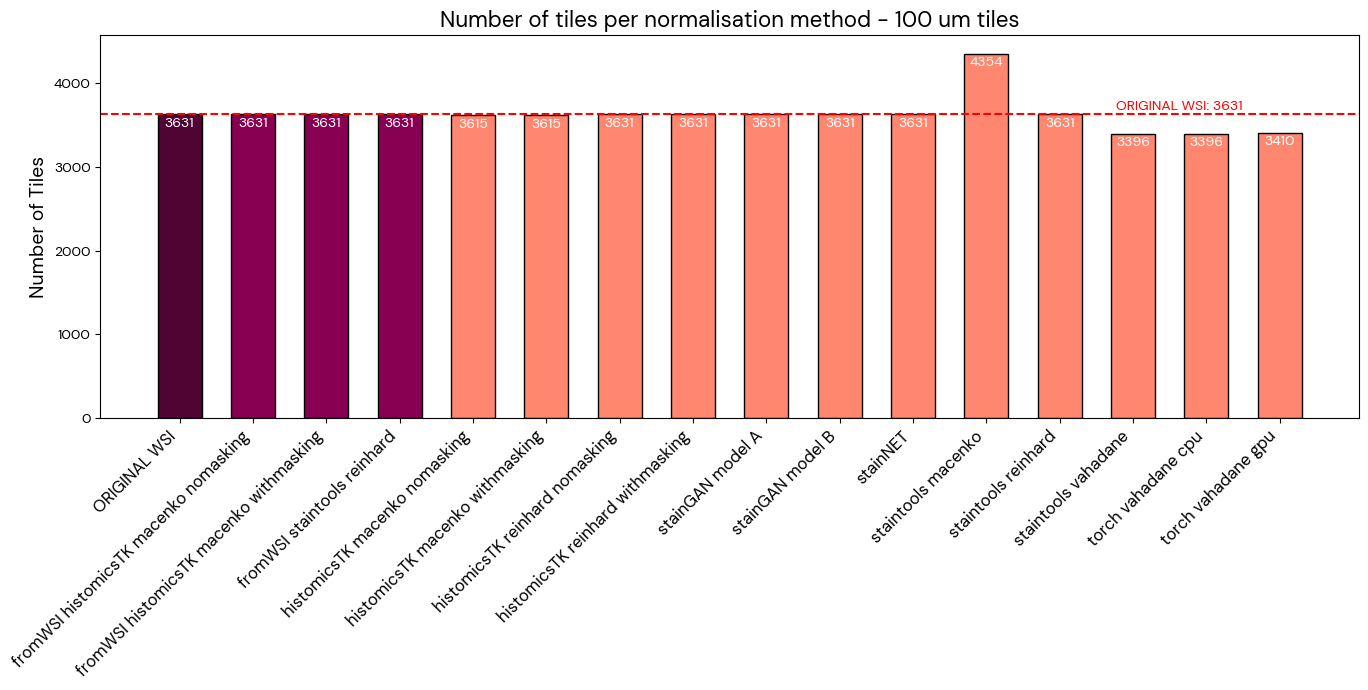

In [10]:
# Filter for Target being '-' or 'target_is_reference_full'
df_filetered_100 = final_summary_for_all_100um_normalised_tiles[final_summary_for_all_100um_normalised_tiles["Target"].isin(["-", "target_is_reference_full"])]
# Highlight "ORIGINAL WSI" separately
original_value = df_filetered_100[df_filetered_100["Normalization Method"] == "ORIGINAL WSI"]["Number of tiles"].iloc[0]

# New names for better appearence
new_names = [i.replace("_", " ") for i in df_filetered_100["Normalization Method"]]

# Choose the colors. I'm using Karolinska Institutet colors, which are given in RGB values, but MatPlotLib uses colors in range 0:1, so we have to normalize them
def rgb_to_tuple(rgb_string):
    # Split the string and normalize each value to [0, 1]
    return tuple(int(x) / 255.0 for x in rgb_string.split(":"))

bar_colors = [
    rgb_to_tuple("79:4:51") if method == "ORIGINAL WSI" 
    else rgb_to_tuple("135:0:82") if method.startswith("fromWSI") 
    else rgb_to_tuple("255:135:111") 
    for method in df_filetered_100["Normalization Method"]
]

# Create the bar plot
plt.figure(figsize=(14, 7))
bars = plt.bar(
    new_names, 
    df_filetered_100["Number of tiles"], 
    color=bar_colors, 
    edgecolor="black", 
    width=0.6
)

# Add a horizontal line for "ORIGINAL WSI"
plt.axhline(original_value, color="red", linestyle="--", linewidth=1.5)
plt.text(
    len(df_filetered_100) - 1.5, original_value + 50,  # Position of the text slightly above the line
    f"ORIGINAL WSI: {original_value}", 
    color="red", 
    fontsize=10, 
    ha="right"
)

# Rotate the method names
plt.xticks(rotation=45, ha="right", fontsize=12)

# Remove legend
plt.gca().legend_ = None

# Add the values inside the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height - 150,  # Slightly below the top
        f"{int(height)}", 
        ha="center", 
        color="white", 
        fontsize=10, 
        weight="bold"
    )

# Improve plot appearance
plt.title("Number of tiles per normalisation method - 100 um tiles", fontsize=16)
plt.ylabel("Number of Tiles", fontsize=14)
#plt.xlabel("Normalization Method", fontsize=12)
#plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### 1.1.2 - 55 μm normalised tiles
Now, let's repeat the previous step but with the 55 μm tiles.

In [11]:
path_to_55um_normalised_tiles = os.path.join(PATH_TO_NORMALISED_TILES, "tiles_55/")
path_to_55um_normalised_tiles

df_55_norm_tiles = normalisations_summary_from_tiles(path_to_55um_normalised_tiles)
#df_55_norm_tiles.to_csv(f"{path_to_55um_normalised_tiles}summary_normalised_tiles_from_tiling_55um.csv")
df_55_norm_tiles

,Normalization Method,Target,Number of tiles,Path to folder
0,histomicsTK_macenko_nomasking,target_is_reference_full,3592,/disk2/user/gabgam/work/gigi_env/the_project/2...
1,histomicsTK_macenko_withmasking,target_is_reference_full,3592,/disk2/user/gabgam/work/gigi_env/the_project/2...
2,histomicsTK_reinhard_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
3,histomicsTK_reinhard_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
4,stainGAN_model_A,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
5,stainGAN_model_B,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
6,stainNET,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
7,staintools_macenko,target_is_reference_full,3189,/disk2/user/gabgam/work/gigi_env/the_project/2...
8,staintools_reinhard,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
9,staintools_vahadane,target_is_reference_full,3199,/disk2/user/gabgam/work/gigi_env/the_project/2...


In [12]:
df_from_wsis_55_norm_tiles = pd.DataFrame()

# looping over all the paths to the tiles derived from WSIs
for path in paths_to_tiles_from_wsis:
    
    path_to_55 = os.path.join(path, "tiles_100/")
    path_to_55
    
    df = normalisations_summary_from_WSI(path_to_55, IMAGE_VERSION_AND_COORDINATE_SYSTEM)
    df_from_wsis_55_norm_tiles = pd.concat([df_from_wsis_55_norm_tiles, df], ignore_index=True)
    
#df_from_wsis_55_norm_tiles.to_csv(f"{path_to_55}summary_tiles_from_WSIs_55um.csv")
df_from_wsis_55_norm_tiles

Processing folder: v3_allspots
3631
Processing folder: v3_allspots_histomicsTK_macenko_nomasking_target_is_reference_full
3631
Processing folder: v3_allspots_histomicsTK_macenko_withmasking_target_is_reference_full
3631
Processing folder: v3_allspots_staintools_reinhard_target_is_reference_full
3631


,Normalization Method,Target,Number of tiles,Path to folder
0,ORIGINAL WSI,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
1,fromWSI_histomicsTK_macenko_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
2,fromWSI_histomicsTK_macenko_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
3,fromWSI_staintools_reinhard,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...


In [13]:
final_summary_for_all_55um_normalised_tiles = pd.concat([df_from_wsis_55_norm_tiles, df_55_norm_tiles])

# save the table
final_summary_for_all_55um_normalised_tiles.to_csv(f"{path_to_55um_normalised_tiles}final_summary_for_all_55um_normalised_tiles.csv")

final_summary_for_all_55um_normalised_tiles

,Normalization Method,Target,Number of tiles,Path to folder
0,ORIGINAL WSI,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
1,fromWSI_histomicsTK_macenko_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
2,fromWSI_histomicsTK_macenko_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
3,fromWSI_staintools_reinhard,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/1...
0,histomicsTK_macenko_nomasking,target_is_reference_full,3592,/disk2/user/gabgam/work/gigi_env/the_project/2...
1,histomicsTK_macenko_withmasking,target_is_reference_full,3592,/disk2/user/gabgam/work/gigi_env/the_project/2...
2,histomicsTK_reinhard_nomasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
3,histomicsTK_reinhard_withmasking,target_is_reference_full,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
4,stainGAN_model_A,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...
5,stainGAN_model_B,-,3631,/disk2/user/gabgam/work/gigi_env/the_project/2...


Let's have a more direct view at it as a histogram.

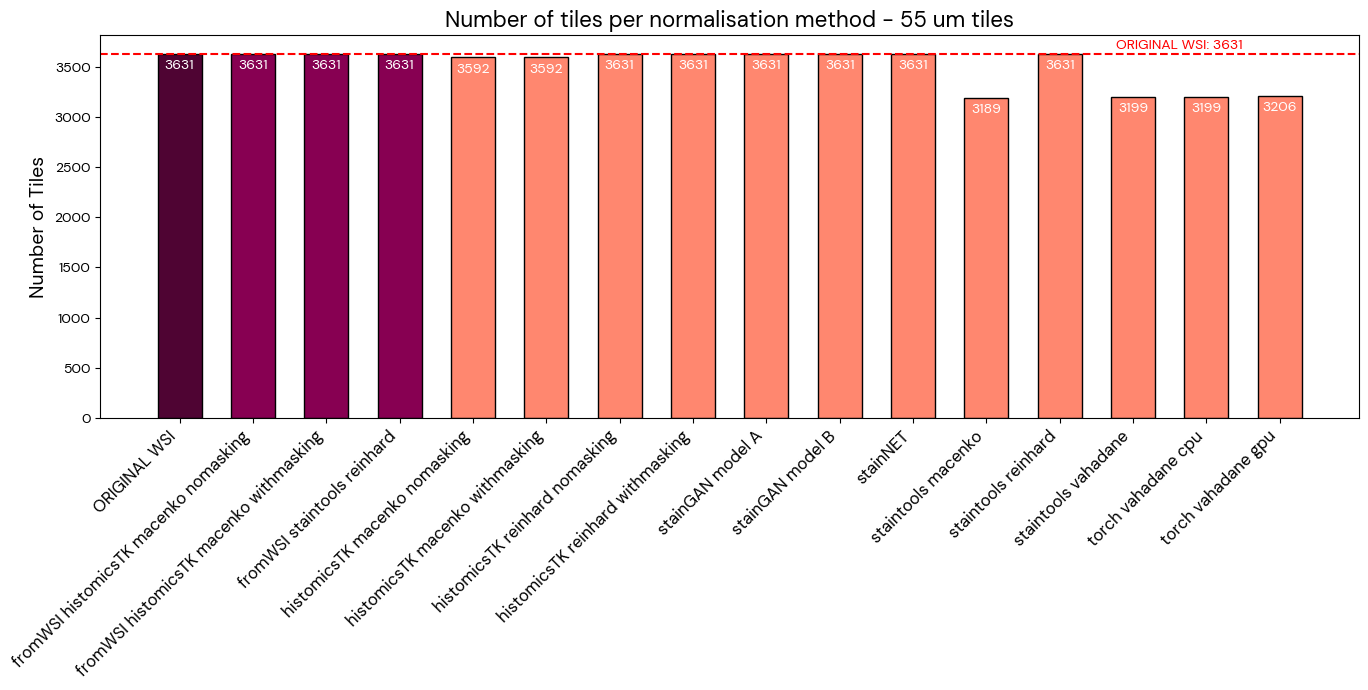

In [14]:
# Filter for Target being '-' or 'target_is_reference_full'
df_filetered_55 = final_summary_for_all_55um_normalised_tiles[final_summary_for_all_55um_normalised_tiles["Target"].isin(["-", "target_is_reference_full"])]
# Highlight "ORIGINAL WSI" separately
original_value = df_filetered_55[df_filetered_55["Normalization Method"] == "ORIGINAL WSI"]["Number of tiles"].iloc[0]

# New names for better appearence
new_names = [i.replace("_", " ") for i in df_filetered_55["Normalization Method"]]

# Choose the colors. I'm using Karolinska Institutet colors, which are given in RGB values, but MatPlotLib uses colors in range 0:1, so we have to normalize them
def rgb_to_tuple(rgb_string):
    # Split the string and normalize each value to [0, 1]
    return tuple(int(x) / 255.0 for x in rgb_string.split(":"))

bar_colors = [
    rgb_to_tuple("79:4:51") if method == "ORIGINAL WSI" 
    else rgb_to_tuple("135:0:82") if method.startswith("fromWSI") 
    else rgb_to_tuple("255:135:111") 
    for method in df_filetered_55["Normalization Method"]
]

# Create the bar plot
plt.figure(figsize=(14, 7))
bars = plt.bar(
    new_names, 
    df_filetered_55["Number of tiles"], 
    color=bar_colors, 
    edgecolor="black", 
    width=0.6
)

# Add a horizontal line for "ORIGINAL WSI"
plt.axhline(original_value, color="red", linestyle="--", linewidth=1.5)
plt.text(
    len(df_filetered_55) - 1.5, original_value + 50,  # Position of the text slightly above the line
    f"ORIGINAL WSI: {original_value}", 
    color="red", 
    fontsize=10, 
    ha="right"
)

# Rotate the method names
plt.xticks(rotation=45, ha="right", fontsize=12)

# Remove legend
plt.gca().legend_ = None

# Add the values inside the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height - 150,  # Slightly below the top
        f"{int(height)}", 
        ha="center", 
        color="white", 
        fontsize=10, 
        weight="bold"
    )

# Improve plot appearance
plt.title("Number of tiles per normalisation method - 55 um tiles", fontsize=16)
plt.ylabel("Number of Tiles", fontsize=14)
#plt.xlabel("Normalization Method", fontsize=12)
#plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

---

# 2. - Quality control
As we've just seen, not all the methods are always successfully computed and the not-computed tiles are saved in `.txt` files in the respective folders named `0_failed_to_normalize.txt`.\
Let's take a quick look at one of these and the errors stored in it.

In [15]:
normalisation_log = "0_failed_to_normalise.txt"
log_dictionary_example = {}

# let's select the method from the previously created dataframe
EXAMPLE_METHOD = final_summary_for_all_55um_normalised_tiles[final_summary_for_all_55um_normalised_tiles["Normalization Method"] == "staintools_macenko"]
print(f"Number of normalised tiles form this method: {EXAMPLE_METHOD['Number of tiles'].iloc[0]}\n")

with open(os.path.join(EXAMPLE_METHOD["Path to folder"].iloc[0], 
                       normalisation_log), "r") as log:
    temp = [error.rstrip("\n").split(": ")[1] for error in log.readlines()[1:]] # removed the first line (title) and last (empty new line, part of the .rstrip("\n"))
    print(temp)

    # Let's created a counter dictionary for every log
    for i in temp:
        log_dictionary_example[i] = log_dictionary_example.get(i, 0) + 1
    #print(log_dictionary_example)
    
    log_df_example = pd.DataFrame.from_dict(log_dictionary_example, orient='index', columns = ["Counts"])

    print(f"Maximum number of tiles: {max_number_of_tiles} \nFailed to normalise for this method: {len(temp)} \nDifference: {max_number_of_tiles} - {len(temp)} = {max_number_of_tiles - len(temp)} \n")

log_df_example

Number of normalised tiles form this method: 3189

['Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', '0-dimensional array given. Array must be at least two-dimensional', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', '0-dimensional array given. Array must be at least two-dimensional', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', 'Empty tissue mask computed', '0-dimensional array given. Array must be at least two-dimen

,Counts
Empty tissue mask computed,432
0-dimensional array given. Array must be at least two-dimensional,10


Let's see what is wrong with these tiles by simply visualising them.

22
484


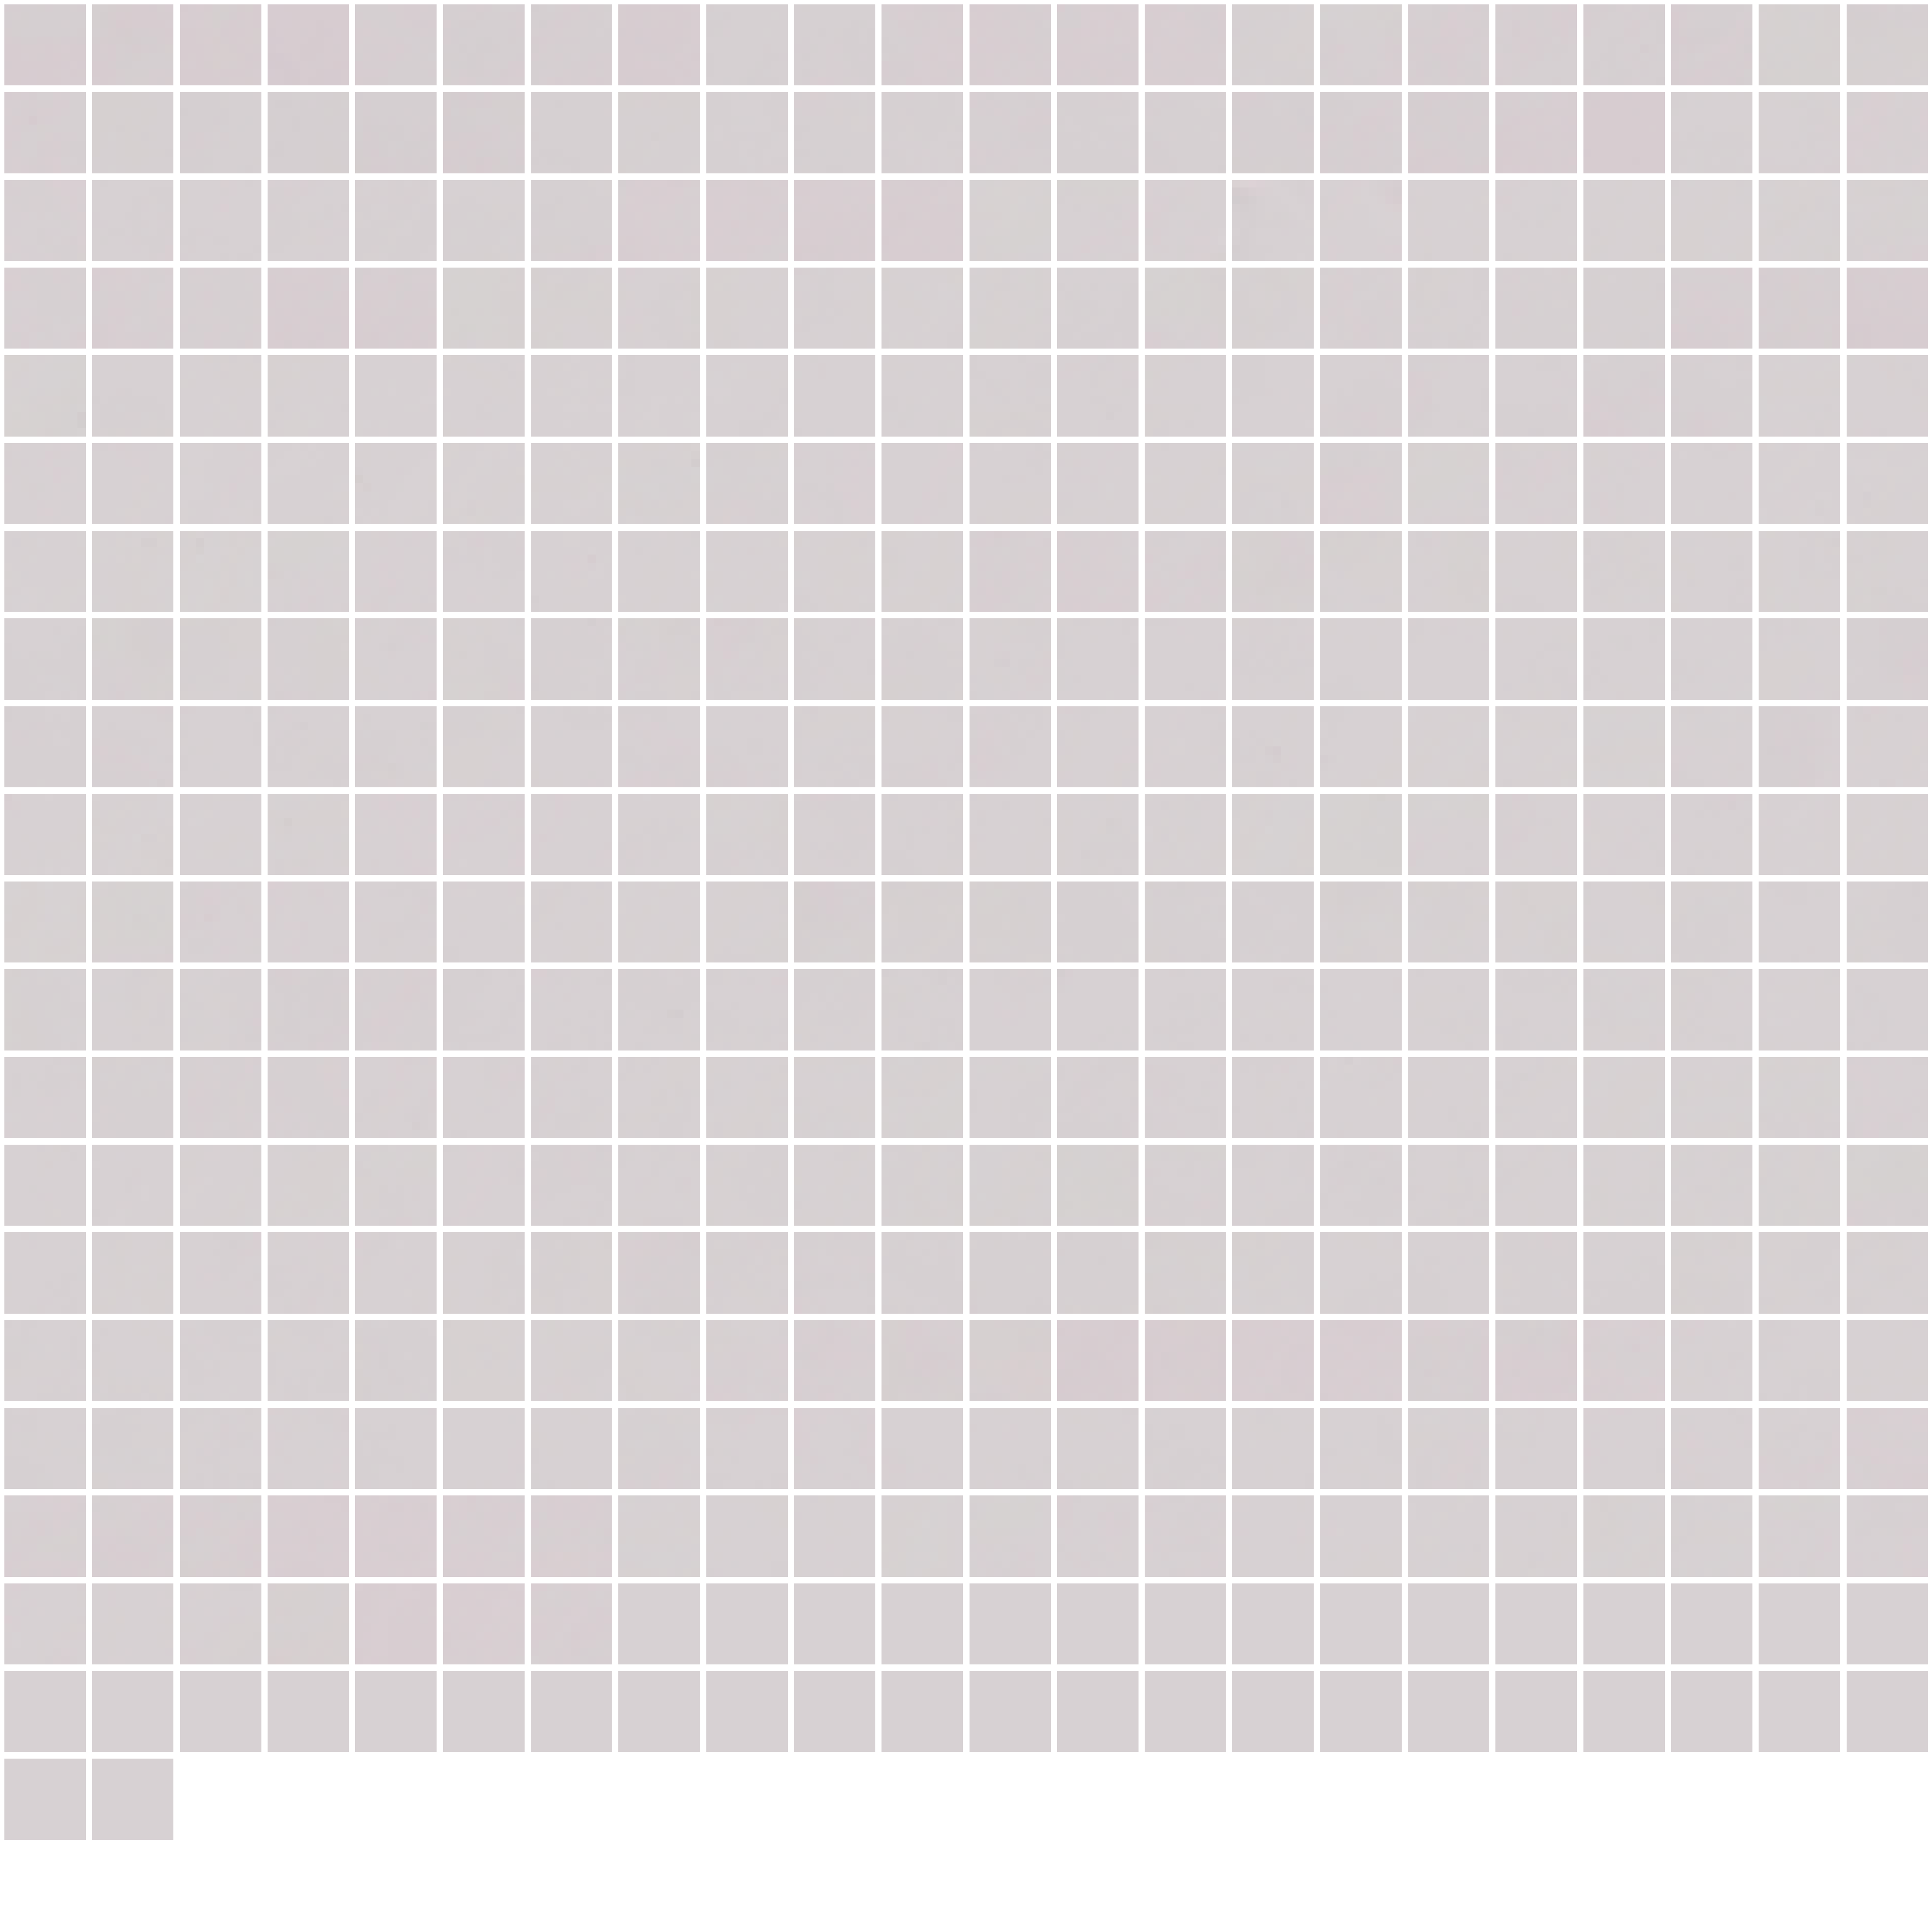

In [16]:
with open(os.path.join(EXAMPLE_METHOD["Path to folder"].iloc[0], 
                       normalisation_log), "r") as log:
    failed_tiles = [error.rstrip("\n").split(": ")[0] for error in log.readlines()[1:]] # removed the first line (title) and last (empty new line, part of the .rstrip("\n"))


# number of tiles per column and rows
useless_param_for_plot = int(round((math.sqrt(len(failed_tiles))), 0)) + 1 # the tiles will be plotted in a "squared" plot, here I'm calculating the number of tiles per border
print(useless_param_for_plot)
print(useless_param_for_plot*useless_param_for_plot)

# Number of rows and columns for the grid
n_rows, n_cols = useless_param_for_plot, useless_param_for_plot


# Create a figure, axes amd font size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows*2, n_cols*2))
font = 10
size_for_plotting = (10, 10)

# Plot each image
for i, ax in enumerate(axes.flat):
    if i < len(failed_tiles):

        # case 1: target image
        tile = Image.open(failed_tiles[i])
        
        resized_tile = tile.resize(size_for_plotting, Image.Resampling.LANCZOS)
        
        ax.imshow(resized_tile) 
         
    ax.axis("off")  # Hide the axis

# Adjust layoutà
#plt.title("Tiles that failed normalisation", fontsize=n_rows*2, loc = "center")
plt.tight_layout()
plt.show()


Now, that's curious, because I thought that I already removed the white parts when I selected the spots on Loupe Browser.\
Let's see where are they distributed in the WSI.

Now, my thought is, what if the original cropping function was wrong? Yes, it was. the pixels on the x and y axis are inverted as it can be seen in this function which simply draws the rectangle of the cropping area.\
In a very brute way:

In [32]:
def wrong_draw_tiles_on_wsi(wsi_image, coords_df, tile_size, output_path=None):
    """
    Draws rectangles on the whole slide image (WSI) based on the spot coordinates.

    :param wsi_image: PIL Image object of the full-resolution WSI
    :param coords_df: DataFrame containing spot coordinates with 'pxl_col' and 'pxl_row'
    :param tile_size: Size of each tile in pixels
    :param output_path: (Optional) Path to save the new WSI with drawn rectangles
    :return: Image with drawn rectangles
    """
    
    # Convert image to RGB if not already
    wsi_image = wsi_image.convert("RGB")
    draw = ImageDraw.Draw(wsi_image)

    for _, row in coords_df.iterrows():
        if row['in_tissue']:
            x_pxl, y_pxl = row["pxl_col"], row["pxl_row"]

            # Compute tile boundaries (same logic as crop_tile_satac)
            left = x_pxl - round(tile_size / 2)
            upper = y_pxl - round(tile_size / 2)
            right = x_pxl + round(tile_size / 2)
            lower = y_pxl + round(tile_size / 2)

            # Draw rectangle on WSI
            draw.rectangle([left, upper, right, lower], outline="blue", width=20)

    width_in_pixels = 2000
    height_in_pixels = round((wsi_image.size[1] * width_in_pixels / wsi_image.size[0]))
    new_size = width_in_pixels, height_in_pixels
    
    high_res_image = wsi_image.resize(new_size, Image.Resampling.LANCZOS)
    high_res_image.save(output_path)
    # Save if output path is provided
    # if output_path:
    #     os.makedirs(os.path.dirname(output_path), exist_ok=True)
    #     wsi_image.save(output_path)
    #     print(f"Annotated WSI saved at: {output_path}")

    return high_res_image

In [33]:
# Imports
IMAGE_PATH = f'../data/spatial_atac/modified_images/BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.jpg'

# open the image without pixels limits and store the size (pixel, pixel)
Image.MAX_IMAGE_PIXELS = None
full_res_image = Image.open(IMAGE_PATH)

# tissue position list file
satac_fake_tissue_position_list = pd.read_csv("../1_tiling/outputs/satac_C1/satac_C1_v3_allspots_fake_tissue_position_list.csv")

# 55 μm
spot_diameter = 55
scale_factor_spot_diameter = float(satac_fake_tissue_position_list["diameter"][0])
print("55μm-spot's diameter in pixels: ~", round(scale_factor_spot_diameter), "px")

# saving path
saving_path = f"./figures/wrong_coordinates_for_cropping_{spot_diameter}um.jpg"

55μm-spot's diameter in pixels: ~ 378 px


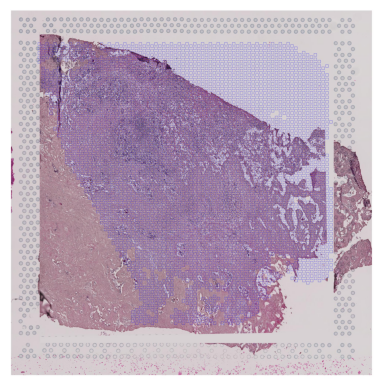

In [34]:
# Example usage
annotated_wsi = wrong_draw_tiles_on_wsi(full_res_image, satac_fake_tissue_position_list, scale_factor_spot_diameter, saving_path)

# Show the image with drawn tiles
img = mpimg.imread(f'{saving_path}')
plt.axis("off")
imgplot = plt.imshow(img)


As we can see, the tiling is not correct!\
Let's modify the function.

In [36]:
def correct_draw_tiles_on_wsi(wsi_image, coords_df, tile_size, output_path=None):
    """
    Draws rectangles on the whole slide image (WSI) based on the spot coordinates.

    :param wsi_image: PIL Image object of the full-resolution WSI
    :param coords_df: DataFrame containing spot coordinates with 'pxl_col' and 'pxl_row'
    :param tile_size: Size of each tile in pixels
    :param output_path: (Optional) Path to save the new WSI with drawn rectangles
    :return: Image with drawn rectangles
    """
    
    # Convert image to RGB if not already
    wsi_image = wsi_image.convert("RGB")
    draw = ImageDraw.Draw(wsi_image)

    for _, row in coords_df.iterrows():
        if row['in_tissue']:
            x_pxl, y_pxl = row["pxl_row"], row["pxl_col"]

            # Compute tile boundaries (same logic as crop_tile_satac)
            left = x_pxl - round(tile_size / 2)
            upper = y_pxl - round(tile_size / 2)
            right = x_pxl + round(tile_size / 2)
            lower = y_pxl + round(tile_size / 2)

            # Draw rectangle on WSI
            draw.rectangle([left, upper, right, lower], outline="blue", width=20)

    width_in_pixels = 2000
    height_in_pixels = round((wsi_image.size[1] * width_in_pixels / wsi_image.size[0]))
    new_size = width_in_pixels, height_in_pixels
    
    high_res_image = wsi_image.resize(new_size, Image.Resampling.LANCZOS)
    high_res_image.save(output_path)
    # Save if output path is provided
    # if output_path:
    #     os.makedirs(os.path.dirname(output_path), exist_ok=True)
    #     wsi_image.save(output_path)
    #     print(f"Annotated WSI saved at: {output_path}")

    return high_res_image

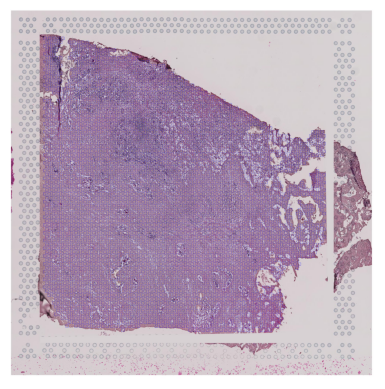

In [37]:
# saving path
saving_path = f"./figures/correct_coordinates_for_cropping_{spot_diameter}um.jpg"

# Example usage
annotated_wsi = correct_draw_tiles_on_wsi(full_res_image, satac_fake_tissue_position_list, scale_factor_spot_diameter, saving_path)

# Show the image with drawn tiles
img = mpimg.imread(f'{saving_path}')
plt.axis("off")
imgplot = plt.imshow(img)


Now I have to rerun everything...